In [2]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


In [4]:
train = pd.read_csv("train/X_train.txt", header=None, delim_whitespace=True).values
y_train = pd.read_csv("train/y_train.txt", header = None, delim_whitespace=True).values

test = pd.read_csv("test/X_test.txt", header=None, delim_whitespace=True).values  
y_test = pd.read_csv("test/y_test.txt", header = None, delim_whitespace=True).values

In [5]:
def gen_features(series, feature_vector):
    feature_vector.append(series.mean())
    feature_vector.append(series.std())
    feature_vector.append(series.max())
    feature_vector.append(series.kurtosis())
    feature_vector.append(series.skew())
    feature_vector.append(np.quantile(series,0.01))
    feature_vector.append(np.quantile(series,0.05))
    feature_vector.append(np.quantile(series,0.95))
    feature_vector.append(np.quantile(series,0.99))
    feature_vector.append(np.abs(series).max())
    feature_vector.append(np.abs(series).mean())
    feature_vector.append(np.abs(series).std())

In [29]:
header = ["mean", "std", "max", "kur", "skew", "qt01", "qt05", "qt95", 
                "qt99", "absmax", "absmean", "absstd"]

In [30]:
X_train = []
#y_train = pd.Series()
for row in train:
    feature_vector = []
    gen_features(pd.Series(row), feature_vector)
    X_train.append(feature_vector)
    #y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_train = pd.DataFrame(X_train)
X_train.columns = header

In [63]:
X_test = []
#y_train = pd.Series()
for row in test:
    feature_vector = []
    gen_features(pd.Series(row), feature_vector)
    X_test.append(feature_vector)
    #y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_test = pd.DataFrame(X_test)
X_test.columns = header

In [33]:
import lightgbm as lgb

/Users/francesco/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [45]:
params = {#"metric" : "accuracy", 
          #"n_jobs" : -1, 
          #"objective" : "multiclass",
          "learning_rate": 0.03,
          "n_estimators" : 100,
          "min_split_gain": 0.1,
          "boosting_type" : 'gbdt'
         }


In [46]:
model = lgb.LGBMClassifier(**params)

In [47]:
model.fit(X_train, np.ravel(y_train))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.03, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [65]:
sum(model.predict(X_test)==np.ravel(y_test))/len(X_test)

0.6019681031557517

In [67]:
import shap

In [68]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [78]:
X_train.values[0,:]

array([-0.6169734 ,  0.58859767,  1.        ,  0.54951903,  1.36445844,
       -1.        , -0.99997811,  0.70958377,  0.99183623,  1.        ,
        0.78857704,  0.32375754])

In [91]:
len(shap_values)

6

In [101]:
X_train.iloc[0]

mean      -0.616973
std        0.588598
max        1.000000
kur        0.549519
skew       1.364458
qt01      -1.000000
qt05      -0.999978
qt95       0.709584
qt99       0.991836
absmax     1.000000
absmean    0.788577
absstd     0.323758
Name: 0, dtype: float64

In [110]:
explainer.expected_value

[-0.6650015467116543,
 -0.7517916140368219,
 -0.7784868921560514,
 -0.40496693433683967,
 -0.4727811599776929,
 -0.44147276872788804]

In [119]:
y_train[0]

array([5])

In [120]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])
i = 5
shap.force_plot(explainer.expected_value[i], 
                shap_values[i][0,:], 
                X_train.values[0,:],
                X_train.columns,
               )


In [125]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])
i = 0
shap.force_plot(explainer.expected_value[i], 
                shap_values[i], 
                X_train.values,
                X_train.columns,
               )

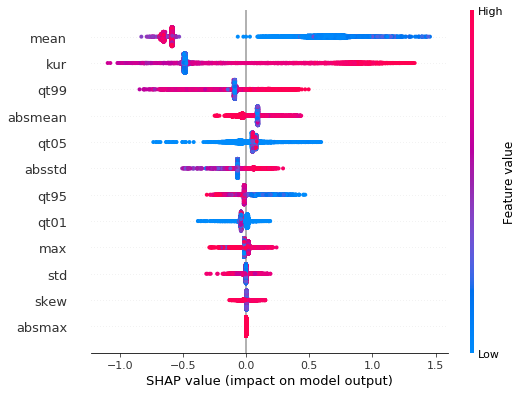

In [132]:
shap.summary_plot(shap_values[4], X_train, X_train.columns)

In [102]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

In [103]:
len(shap_values)

6

In [107]:
# init the JS visualization code
shap.initjs()

# transform the indexes to words
"""
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])
"""

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[4][0], link = "logit")

TypeError: only size-1 arrays can be converted to Python scalars

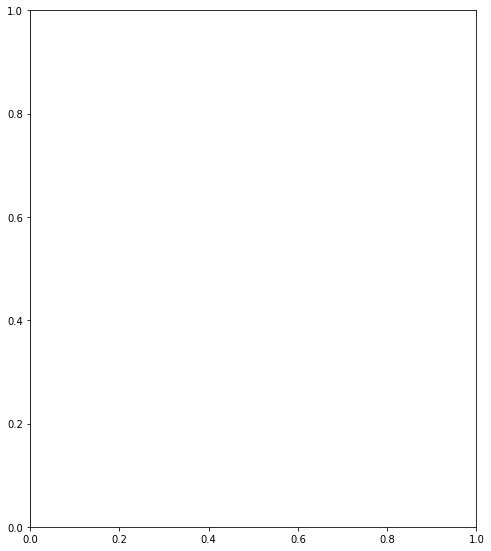

In [106]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [25]:
shap_values[2][0].shape

(561, 1)

In [81]:
plt.plot(shap_values[4][0])

TypeError: scatter() missing 1 required positional argument: 'y'

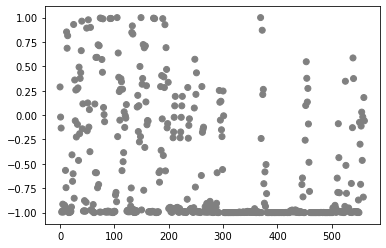

In [99]:
plt.scatter( range(561),X_train[0], color = coloriprova)

In [63]:
from matplotlib.colors import to_rgba

In [92]:
to_rgb([1])

ValueError: RGBA sequence should have length 3 or 4

In [95]:
coloriprova=[[0.5,0.5,0.5] for i in range(len(shap_values[4][0].flatten()))]

In [97]:
len(shap_values[4][0].flatten())

561

In [78]:
#from numpy import arange

#from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap


# ======
## data:

N = len(shap_values[4][0].flatten())
data = shap_values[4][0].flatten()


# =================
## custom colormap:

# red-green colormap:
cdict = {'red':   [(0.0, 1.0, 1.0),  # red decreases
                   (1.0, 0.0, 0.0)],

         'green': [(0.0, 0.0, 0.0),  # green increases
                   (1.0, 1.0, 1.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = LinearSegmentedColormap('RedGreen', cdict, N)
colors = cm.get_cmap(red_green_cm, N)

In [79]:
colors

In [48]:
X_train[0][:,2].shape

(128,)